### Model and Train

In [2]:
import torch
import torch.nn.functional as F 
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    
    def __init__(self, dataset, feature_size):
        super(GNN, self).__init__()
        input_size = dataset[0].num_features
        output_size = 2 # binary classification
        self.conv1 = GCNConv(in_channels=input_size, out_channels=feature_size)
        self.conv2 = GCNConv(in_channels=feature_size, out_channels=output_size)

    def forward(self, x, edge_index, edge_attr=None):
            
        # First Message Passing Layer
        x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_attr)
        x = x.relu()
            
        # Second Message Passing Layer
        x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_attr)
        return x


#     def __init__(self, dataset, feature_size):
#         super(GNN, self).__init__()

#         input_size = dataset[0].num_features
#         output_size = 2
#         self.conv1 = GCNConv(in_channels=input_size, out_channels=feature_size)
#         self.conv2 = GCNConv(in_channels=feature_size, out_channels=feature_size)
#         self.d1 = torch.nn.Linear(feature_size, output_size)

#     def forward(self, x, edge_index, edge_attr=None):
#         # First Message Passing Layer
#         x = x.to(torch.float32)
#         x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_attr)
#         x = x.relu()
#         x = F.dropout(x, p=0.2, training=self.training)

#         # Second Message Passing Layer
#         x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_attr)
#         x = x.relu()
#         x = F.dropout(x, p=0.2, training=self.training)

#         # Output layer 
#         x = F.softmax(self.d1(x), dim=1)
#         return x

In [3]:
import collections
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as nodeSplit
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm
# from model import GNN

class Train():
    def __init__(self, model, data, epochs = 10, learning_rate = 0.01):
        self.data = data
        self.model = model
        self.epochs = epochs
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.train_network()

    def train_network(self):
        data = self.data
        optimizer = self.optimizer
        epochs = self.epochs
        
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []

        for epoch in range(epochs + 1):
            optimizer.zero_grad()
#             output = self.model(data.x, data.edge_index)
            output = self.model(data.x, data.edge_index, data.edge_attr)
            loss = self.loss_func(output[data.train_mask], data.y[data.train_mask].long())
            loss.backward()
            optimizer.step()
            train_losses += [loss.item()]
            train_correct = torch.argmax(output[data.train_mask], dim=1) == data.y[data.train_mask]
            
#             print("Predicted label vs actual label:")
#             print(torch.argmax(output[data.train_mask], dim=1))
#             print(data.y[data.train_mask])
#             print()
            
            train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
            train_accs += [train_acc]

            test_correct = torch.argmax(output[data.test_mask], dim=1) == data.y[data.test_mask]
            test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
            test_accs += [test_acc]

            print(f"Epoch {epoch + 1}/{epochs}, Train_Loss: {loss:.4f}, Train_Accuracy: {train_acc:.4f}, Test_Accuracy: {test_acc:.4f}")
        
        plt.plot(train_losses)
        plt.show()

        plt.plot(train_accs)
        plt.plot(test_accs) 
        plt.show()

In [4]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

def transform_and_split(data):
    # Normalize node features and transform data type
    data.x = normalize(data.x, axis=1, norm='max')
    data.x = torch.from_numpy(data.x).to(torch.float64)
    data.y = torch.from_numpy(data.y).apply_(lambda x:  1 if (x > 0) else 0) # Change y into {0, 1} for binary classification
    data.y = data.y.to(torch.float64)    
    data.edge_attr = data.edge_attr.to(torch.double)


    # Split into train/test set
    split = nodeSplit(split="train_rest", num_splits = 1, num_val = 0.0, num_test= 0.2)
    masked_data = split(data)

    print("Training samples:", torch.sum(masked_data.train_mask).item())
    print("Validation samples:", torch.sum(masked_data.val_mask ).item())
    print("Test samples:", torch.sum(masked_data.test_mask ).item())
    print_basic_info(masked_data)
    return masked_data

In [5]:
def print_basic_info(data):
    print()
    print(data)
    print('===========================================================================================================')

    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

### Get and split data

In [6]:
path = "../../data/processed/twitter/2018_q1.pt" # Customize...
dataset = torch.load(path)
data = dataset[0]
transformed_data = transform_and_split(data)

[[ 43.06499863  43.05749893  43.25749969  43.75        43.58750153
   43.58250046  43.57249832  43.81999969  44.27249908  44.04750061
   44.77500153  44.81499863  44.61500168  44.25        44.25999832
   43.55500031  42.77750015  42.87749863  41.99000168  41.74250031
   41.85749817  41.94499969  40.125       39.12250137  40.75749969
   39.88499832  38.78749847  39.10250092  40.67750168  41.08499908
   41.84249878  43.24750137  43.10749817  42.96250153  42.76750183
   43.125       43.875       44.74250031  44.59749985  44.52999878
   43.75        44.05250168  44.20500183  44.16749954  43.75749969
   44.23500061  44.99499893  45.43000031  44.99250031  44.61000061
   44.66249847  44.50500107  43.82500076  43.81000137  42.81750107
   42.21250153  41.23500061  43.19250107  42.08499908  41.61999893
   41.94499969]
 [177.         180.33999634 179.58000183 180.6499939  180.6000061
  183.38000488 182.86000061 181.96000671 185.03999329 185.53999329
  188.00999451 187.58999634 189.27999878 192.33

### Create model and train

In [6]:
model = GNN(dataset = dataset, feature_size=32)
model = model.to(torch.float64)
print(model)

GNN(
  (conv1): GCNConv(61, 32)
  (conv2): GCNConv(32, 2)
)


Epoch 1/20, Train_Loss: 0.7715, Train_Accuracy: 0.3913, Test_Accuracy: 0.5000
Epoch 2/20, Train_Loss: 0.8041, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 3/20, Train_Loss: 0.7818, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 4/20, Train_Loss: 0.6972, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 5/20, Train_Loss: 0.6871, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 6/20, Train_Loss: 0.7291, Train_Accuracy: 0.3913, Test_Accuracy: 0.5000
Epoch 7/20, Train_Loss: 0.7315, Train_Accuracy: 0.3913, Test_Accuracy: 0.5000
Epoch 8/20, Train_Loss: 0.6990, Train_Accuracy: 0.3913, Test_Accuracy: 0.5000
Epoch 9/20, Train_Loss: 0.6761, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 10/20, Train_Loss: 0.6803, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 11/20, Train_Loss: 0.6955, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 12/20, Train_Loss: 0.7012, Train_Accuracy: 0.6087, Test_Accuracy: 0.5000
Epoch 13/20, Train_Loss: 0.6927, Train_Accuracy: 0.6087, Test

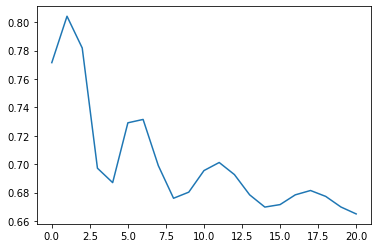

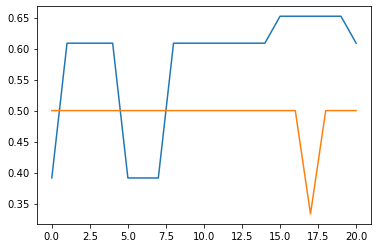

In [7]:
# Customize...
training_result = Train(model = model, data = transformed_data, epochs = 20, learning_rate = 0.01)

In [7]:
transformed_data.edge_index.t()

tensor([[ 0,  3],
        [ 0,  4],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 13],
        [ 0, 22],
        [ 0, 25],
        [ 1,  3],
        [ 1,  4],
        [ 1,  8],
        [ 1,  9],
        [ 1, 10],
        [ 1, 13],
        [ 1, 22],
        [ 1, 25],
        [ 2,  3],
        [ 2,  4],
        [ 2,  8],
        [ 2,  9],
        [ 2, 10],
        [ 2, 13],
        [ 2, 22],
        [ 2, 25],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  3],
        [ 3,  4],
        [ 3,  5],
        [ 3,  6],
        [ 3,  7],
        [ 3,  8],
        [ 3,  9],
        [ 3, 10],
        [ 3, 11],
        [ 3, 12],
        [ 3, 13],
        [ 3, 14],
        [ 3, 15],
        [ 3, 16],
        [ 3, 17],
        [ 3, 18],
        [ 3, 19],
        [ 3, 20],
        [ 3, 21],
        [ 3, 22],
        [ 3, 23],
        [ 3, 24],
        [ 3, 25],
        [ 3, 26],
        [ 3, 27],
        [ 3, 28],
        [ 4,  0],
        [ 4,  1],
        [ 